# EDA

In [21]:
import os
import pandas as pd
import snowflake.connector
from dotenv import load_dotenv  
from scipy import stats
import numpy as np

In [22]:
load_dotenv('../.env')

# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv("SNOWFLAKE_USER"),
    password=os.getenv("SNOWFLAKE_PASSWORD"),
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    warehouse="COMPUTE_WH",
    database="DYNAMIC_PRICING",
    schema="MARTS"
)

print('Connection established')

Connection established


In [23]:
# 1. Define the Query
# I want the Full Log (Granular Data) for Machine Learning
query = """
SELECT * FROM DYNAMIC_PRICING.MARTS.MART_FULL_SALES_LOG 
ORDER BY SALES_DATE DESC
"""

# 2. Run Query & Load into Pandas
# cursor().execute() runs the query, fetchall() gets the data
cur = conn.cursor()
cur.execute(query)
data = cur.fetchall()

# 3. Get Column Names (so the DataFrame isn't just numbers)
col_names = [desc[0] for desc in cur.description]

# 4. Create the DataFrame
df = pd.DataFrame(data, columns=col_names)

# 5. Close Connection (Good practice!)
cur.close()
conn.close()

# 6. Verify
print(f"Success! Loaded {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Success! Loaded 940 rows and 12 columns.


,ORDER_ID,PRODUCT_ID,SALES_DATE,ORDER_PURCHASE_TIMESTAMP,CATEGORY_NAME,OUR_PRICE,BENCHMARK_PRODUCT_NAME,COMPETITOR_PRICE,PRICE_DIFF,TEMPERATURE_C,WEATHER_CONDITION,PRECIPITATION_MM
0,f7dbcda3f48b607b8ed01b6bcd84b92e,"""87cc2aef12eddf0b170234138b0946e0""",2026-02-09,2026-02-09 14:15:55,informatica_acessorios,58.065625,MacBook Air M1,941.859985,-883.794360,23.2,Rain,17.8
1,"""983de0fdf98ff06d6cf1c379f7540f7f""","""5237739bb5fee495dbd337755a138660""",2026-02-09,2026-02-09 21:04:10,relogios_presentes,252.812500,Apple Watch Series 9,158.059998,94.752502,23.2,Rain,17.8
2,"""983de0fdf98ff06d6cf1c379f7540f7f""","""5237739bb5fee495dbd337755a138660""",2026-02-09,2026-02-09 21:04:10,relogios_presentes,252.812500,Apple Watch Series 9,448.119995,-195.307495,23.2,Rain,17.8
3,"""983de0fdf98ff06d6cf1c379f7540f7f""","""5237739bb5fee495dbd337755a138660""",2026-02-09,2026-02-09 21:04:10,relogios_presentes,252.812500,Apple Watch Series 9,199.990005,52.822495,23.2,Rain,17.8
4,"""0f2335c85eae6c232fa46499d5e1e3d2""",b192be433004cc1f10b467c0e9ea309b,2026-02-09,2026-02-09 16:51:47,informatica_acessorios,61.718750,MacBook Air M1,941.859985,-880.141235,23.2,Rain,17.8


In [24]:
print("--- Data Info ---")
df.info()

--- Data Info ---
<class 'pandas.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ORDER_ID                  940 non-null    str           
 1   PRODUCT_ID                940 non-null    str           
 2   SALES_DATE                940 non-null    object        
 3   ORDER_PURCHASE_TIMESTAMP  940 non-null    datetime64[us]
 4   CATEGORY_NAME             940 non-null    str           
 5   OUR_PRICE                 940 non-null    float64       
 6   BENCHMARK_PRODUCT_NAME    940 non-null    str           
 7   COMPETITOR_PRICE          940 non-null    float64       
 8   PRICE_DIFF                940 non-null    float64       
 9   TEMPERATURE_C             940 non-null    float64       
 10  WEATHER_CONDITION         940 non-null    str           
 11  PRECIPITATION_MM          940 non-null    float64       
dtypes: datetime64[u

In [25]:
# Summary statistics for Prices and Weather
# I filter for relevant columns to avoid noise
stats_cols = ['OUR_PRICE', 'COMPETITOR_PRICE', 'TEMPERATURE_C', 'PRECIPITATION_MM', 'PRICE_DIFF']

# Describe generates the stats
print(df[stats_cols].describe().round(2))

       OUR_PRICE  COMPETITOR_PRICE  TEMPERATURE_C  PRECIPITATION_MM  \
count     940.00            940.00         940.00            940.00   
mean      117.05            409.84          27.68              7.36   
std       108.33            452.79           3.62              7.56   
min        47.47            125.79          19.00              0.00   
25%        56.25            142.23          25.00              0.50   
50%        71.22            153.52          27.45              4.50   
75%       152.81            757.01          29.74             13.58   
max      1156.25           2489.52          35.05             27.10   

       PRICE_DIFF  
count      940.00  
mean      -292.79  
std        460.54  
min      -2398.93  
25%       -518.16  
50%        -89.23  
75%        -60.86  
max       1023.42  


In [26]:
# Count unique orders per category
print("--- Sales by Category ---")
print(df['CATEGORY_NAME'].value_counts())

# Count weather conditions
print("\n--- Weather Conditions ---")
print(df['WEATHER_CONDITION'].value_counts())

--- Sales by Category ---
CATEGORY_NAME
relogios_presentes        603
informatica_acessorios    186
telefonia                  67
eletronicos                45
audio                      39
Name: count, dtype: int64

--- Weather Conditions ---
WEATHER_CONDITION
Rain     679
Clear    261
Name: count, dtype: int64


In [27]:
# Check the start and end dates
print(f"Data Start Date: {df['SALES_DATE'].min()}")
print(f"Data End Date:   {df['SALES_DATE'].max()}")
print(f"Total Days:      {(df['SALES_DATE'].max() - df['SALES_DATE'].min()).days}")

Data Start Date: 2025-11-12
Data End Date:   2026-02-09
Total Days:      89


In [28]:
# 1. Define the "Normal" Range (IQR Rule)
Q1 = df['OUR_PRICE'].quantile(0.25)
Q3 = df['OUR_PRICE'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2. Identify the Outliers
outliers = df[(df['OUR_PRICE'] < lower_bound) | (df['OUR_PRICE'] > upper_bound)]

print(f"--- Outlier Report ---")
print(f"Normal Price Range: ${lower_bound:.2f} to ${upper_bound:.2f}")
print(f"Number of Outliers detected: {len(outliers)}")
print(f"Percentage of data that is 'Anomalous': {(len(outliers)/len(df))*100:.2f}%")

# 3. Who are they? (Top 5 Extreme Cases)
print("\n--- Top 5 Most Expensive 'Anomalies' ---")
print(outliers.nlargest(5, 'OUR_PRICE')[['SALES_DATE', 'CATEGORY_NAME', 'OUR_PRICE', 'WEATHER_CONDITION']])

--- Outlier Report ---
Normal Price Range: $-88.59 to $297.66
Number of Outliers detected: 53
Percentage of data that is 'Anomalous': 5.64%

--- Top 5 Most Expensive 'Anomalies' ---
     SALES_DATE           CATEGORY_NAME    OUR_PRICE WEATHER_CONDITION
825  2025-11-19      relogios_presentes  1156.250000             Clear
184  2026-01-20  informatica_acessorios   781.171875              Rain
190  2026-01-19             eletronicos   772.031250              Rain
201  2026-01-17             eletronicos   772.031250              Rain
902  2025-11-13             eletronicos   760.500000              Rain


In [29]:
# 1. Split data into two groups: Rainy Days vs Clear Days
rainy_sales = df[df['WEATHER_CONDITION'] == 'Rain']['OUR_PRICE']
clear_sales = df[df['WEATHER_CONDITION'] == 'Clear']['OUR_PRICE']

# 2. Run the T-Test (Independent samples)
t_stat, p_val = stats.ttest_ind(rainy_sales, clear_sales, equal_var=False)

print(f"--- Hypothesis Test: Rain vs Clear ---")
print(f"Rainy Days Mean Revenue: ${rainy_sales.mean():.2f}")
print(f"Clear Days Mean Revenue: ${clear_sales.mean():.2f}")
print(f"P-Value: {p_val:.5f}")

if p_val < 0.05:
    print("RESULT: Statistically Significant! Rain DOES affect sales.")
else:
    print("RESULT: Not Significant. The difference could be random chance.")

--- Hypothesis Test: Rain vs Clear ---
Rainy Days Mean Revenue: $115.45
Clear Days Mean Revenue: $121.21
P-Value: 0.49386
RESULT: Not Significant. The difference could be random chance.


In [30]:
# I look at 'PRICE_DIFF' (My Price - Competitor)
price_diffs = df['PRICE_DIFF'].dropna() # Remove nulls just in case

# Calculate 95% Confidence Interval
conf_level = 0.95
degrees_freedom = len(price_diffs) - 1
sample_mean = np.mean(price_diffs)
sample_sem = stats.sem(price_diffs) # Standard Error of Mean

confidence_interval = stats.t.interval(conf_level, degrees_freedom, sample_mean, sample_sem)

print(f"\n--- 95% Confidence Interval for Price Difference ---")
print(f"Sample Mean: ${sample_mean:.2f}")
print(f"Range: [${confidence_interval[0]:.2f}, ${confidence_interval[1]:.2f}]")
print("Interpretation: I am 95% confident the 'True' price difference falls in this range.")


--- 95% Confidence Interval for Price Difference ---
Sample Mean: $-292.79
Range: [$-322.27, $-263.31]
Interpretation: I am 95% confident the 'True' price difference falls in this range.


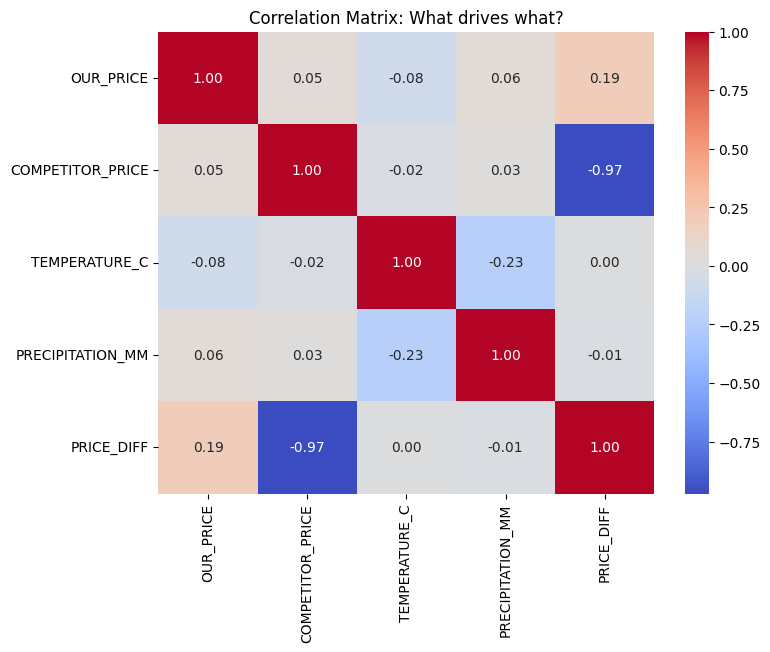

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns only
corr_cols = ['OUR_PRICE', 'COMPETITOR_PRICE', 'TEMPERATURE_C', 'PRECIPITATION_MM', 'PRICE_DIFF']
corr_matrix = df[corr_cols].corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: What drives what?")
plt.show()

In [32]:
import plotly.figure_factory as ff
import numpy as np

# 1. Prepare data (Drop nulls just in case)
v1 = df['OUR_PRICE'].dropna()
v2 = df['COMPETITOR_PRICE'].dropna()

# 2. Create Distribution Plot (Histogram + KDE Curve)
hist_data = [v1, v2]
group_labels = ['My Price', 'Competitor Price']

# Create the plot with custom colors
fig = ff.create_distplot(hist_data, group_labels, 
                         bin_size=25, 
                         show_hist=True, 
                         show_rug=False,
                         colors=['#00D4FF', '#FF5733']) # Blue vs Red

fig.update_layout(title_text='Price Distribution: Me vs. Them')
fig.show()

In [33]:
import plotly.express as px

fig = px.box(df, 
             x="WEATHER_CONDITION", 
             y="OUR_PRICE", 
             color="WEATHER_CONDITION",
             points="all", # Show actual data points too
             title="Revenue Distribution by Weather",
             labels={"OUR_PRICE": "Revenue per Order ($)"})

fig.show()

In [34]:
fig = px.strip(df, 
               x="CATEGORY_NAME", 
               y="OUR_PRICE", 
               color="CATEGORY_NAME", 
               title="Price Consistency by Category")

fig.update_layout(showlegend=False)
fig.show()

In [35]:
# Extract Day of Week (0=Monday, 6=Sunday)
df['day_of_week'] = pd.to_datetime(df['SALES_DATE']).dt.day_name()

# Sort order for the chart
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig = px.box(df, 
             x="day_of_week", 
             y="OUR_PRICE", 
             category_orders={"day_of_week": order},
             title="Sales Distribution by Day of Week",
             color="day_of_week")

fig.show()

In [36]:
import plotly.express as px

# 1. Group by Date to get Total Daily Revenue
daily_revenue = df.groupby('SALES_DATE')['OUR_PRICE'].sum().reset_index()

# 2. Plot the Trend
fig = px.line(daily_revenue, 
              x='SALES_DATE', 
              y='OUR_PRICE',
              title='Daily Revenue Trend (2016-2018 Data Shifted)',
              labels={'OUR_PRICE': 'Total Revenue ($)', 'SALES_DATE': 'Date'})

# Add a "Trendline" to see the general direction
fig.update_traces(line_color='#00D4FF', line_width=2)
fig.show()

In [37]:
# 1. Sum Revenue by Category
category_perf = df.groupby('CATEGORY_NAME')['OUR_PRICE'].sum().reset_index()
category_perf = category_perf.sort_values('OUR_PRICE', ascending=True) # Sort for better chart

# 2. Horizontal Bar Chart
fig = px.bar(category_perf, 
             x='OUR_PRICE', 
             y='CATEGORY_NAME',
             orientation='h', # Horizontal is easier to read
             title='Total Revenue by Category',
             text_auto='.2s', # Show values like "10k"
             color='OUR_PRICE',
             color_continuous_scale='Bluered')

fig.show()

In [38]:
# 1. Pivot Table: Rows=Category, Cols=Weather, Values=Average Daily Revenue
# I aggregate by MEAN to account for different numbers of rainy vs clear days
weather_pivot = df.pivot_table(index='CATEGORY_NAME', 
                               columns='WEATHER_CONDITION', 
                               values='OUR_PRICE', 
                               aggfunc='mean').reset_index()

# 2. Calculate the "Rain Lift" (How much better/worse is Rain?)
# Rain Lift = (Rain Revenue - Clear Revenue) / Clear Revenue
weather_pivot['Rain_Lift'] = (weather_pivot['Rain'] - weather_pivot['Clear']) / weather_pivot['Clear']

# 3. Plot the Lift
fig = px.bar(weather_pivot, 
             x='Rain_Lift', 
             y='CATEGORY_NAME',
             orientation='h',
             title='Impact of Rain on Revenue (Percentage Lift)',
             labels={'Rain_Lift': 'Revenue Change in Rain (%)'},
             color='Rain_Lift',
             color_continuous_scale='RdBu', # Red=Bad, Blue=Good
             text_auto='.1%')

# Add a line at 0% (No impact)
fig.add_vline(x=0, line_dash="dash", line_color="black")
fig.show()

<Figure size 1000x800 with 0 Axes>

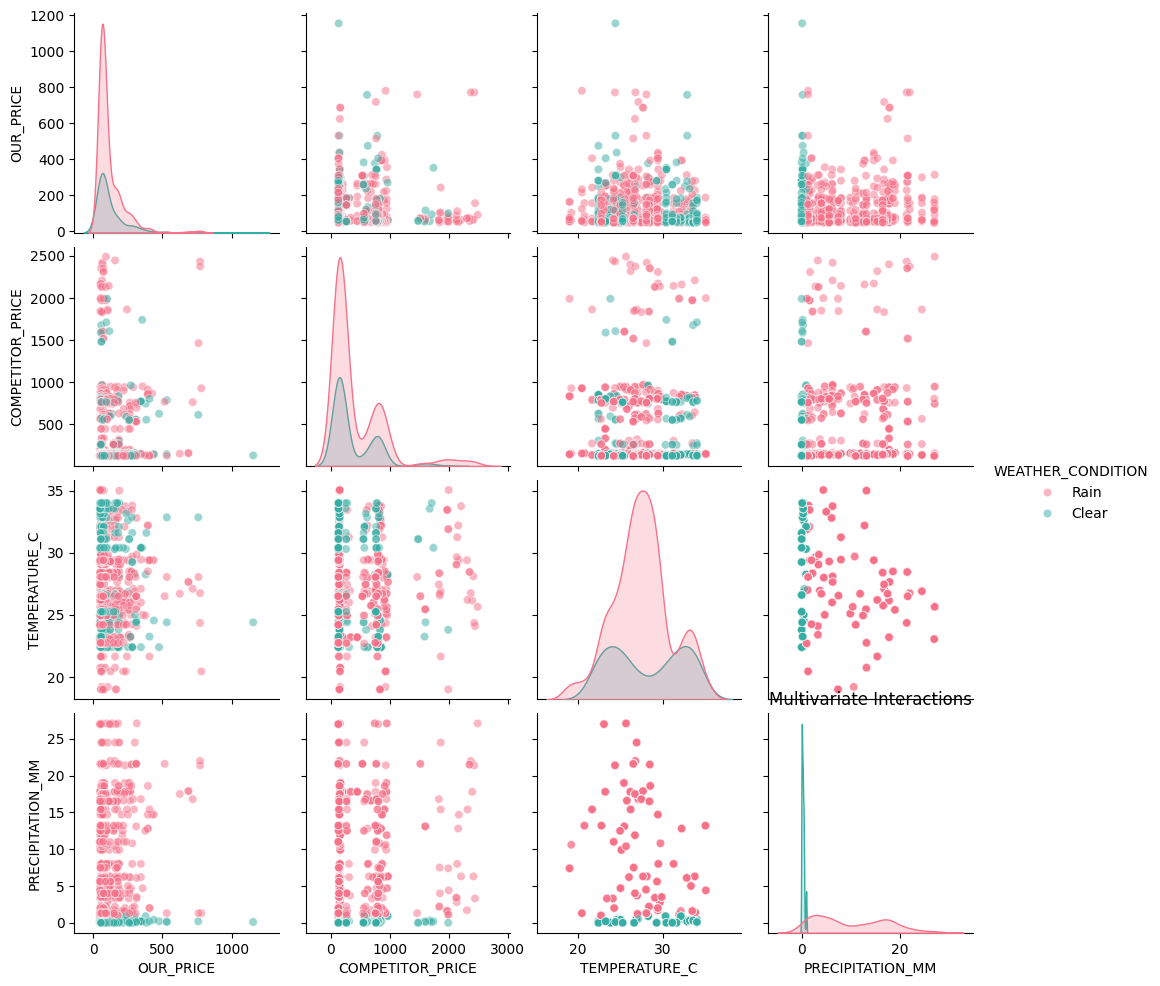

In [39]:
# 1. Select the columns that actually matter
cols_to_plot = ['OUR_PRICE', 'COMPETITOR_PRICE', 'TEMPERATURE_C', 'PRECIPITATION_MM']

# 2. Create the Pairplot
# Hue='WEATHER_CONDITION' lets me see if Rain creates distinct "clusters" of data
plt.figure(figsize=(10, 8))
sns.pairplot(df, vars=cols_to_plot, hue='WEATHER_CONDITION', palette='husl', plot_kws={'alpha': 0.5})
plt.title("Multivariate Interactions")
plt.show()

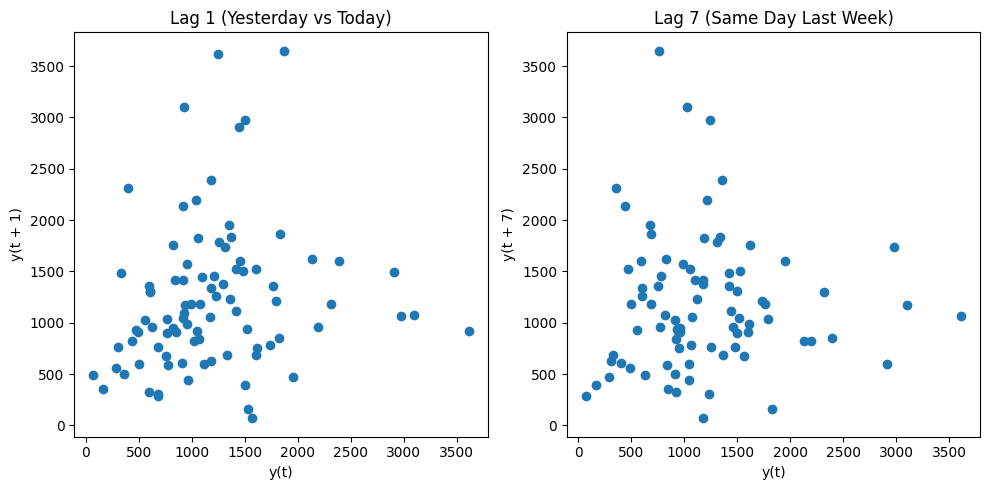

In [40]:
from pandas.plotting import lag_plot

# Resample to Daily Total Revenue (since individual orders are noisy)
daily_sales = df.groupby('SALES_DATE')['OUR_PRICE'].sum()

plt.figure(figsize=(10, 5))

# Plot Lag 1 (Yesterday vs Today)
plt.subplot(1, 2, 1)
lag_plot(daily_sales, lag=1)
plt.title("Lag 1 (Yesterday vs Today)")

# Plot Lag 7 (Last Week vs Today)
plt.subplot(1, 2, 2)
lag_plot(daily_sales, lag=7)
plt.title("Lag 7 (Same Day Last Week)")

plt.tight_layout()
plt.show()